In [4]:
import pymc
import numpy as np
import pandas as pd
import xarray as xr
import copy
import matplotlib.pyplot as plt
import pygemfxns_ensemble_sampling as es
import glob
import os
import run_calibration_list_multiprocess as rc
from pandas.plotting import autocorrelation_plot
import pygemfxns_ensemble_sampling as es
import matplotlib.mlab as mlab
from jupyterthemes import jtplot
from scipy.stats import gaussian_kde
import scipy.stats as stats 

jtplot.style('grade3', fscale=1.3)
jtplot.figsize(x=18, y=10)


In [2]:
filelist = glob.glob(os.path.join('*.pickle'))
print(filelist)
traces = {}
for f in filelist:
    samples = f[:-20]
    name = f[-12:-7]
    print(samples, name)
    traces[(name, samples)] = pymc.database.pickle.load(f)

['10000Samples_10079.pickle', '200Samples_10079.pickle', '3000Samples_10059.pickle', '5000Samples_10075.pickle', '200Samples_10075.pickle', '30000Samples_10075.pickle', '5000Samples_10079.pickle', '10000Samples_10060.pickle', '1000Samples_03473.pickle', '30000Samples_10059.pickle', '30000Samples_10060.pickle', '200Samples_10059.pickle', '3000Samples_10060.pickle', '30000Samples_10079.pickle', '10000Samples_10075.pickle', '1000Samples_10060.pickle', '1000Samples_10059.pickle', '5000Samples_10059.pickle', '200Samples_10060.pickle', '5000Samples_10060.pickle', '1000Samples_10075.pickle', '1000Samples_10079.pickle', '10000Samples_10059.pickle', '3000Samples_10075.pickle', '3000Samples_10079.pickle']
10000 10079
200 10079
3000 10059
5000 10075
200 10075
30000 10075
5000 10079
10000 10060
1000 03473
30000 10059
30000 10060
200 10059
3000 10060
30000 10079
10000 10075
1000 10060
1000 10059
5000 10059
200 10060
5000 10060
1000 10075
1000 10079
10000 10059
3000 10075
3000 10079


In [8]:
traces

{('10079', '10000'): <pymc.database.pickle.Database at 0x7fb7e603c2b0>,
 ('10079', '200'): <pymc.database.pickle.Database at 0x7fb7e704d5f8>,
 ('10059', '3000'): <pymc.database.pickle.Database at 0x7fb7e704d668>,
 ('10075', '5000'): <pymc.database.pickle.Database at 0x7fb7e7064fd0>,
 ('10075', '200'): <pymc.database.pickle.Database at 0x7fb7e7072470>,
 ('10075', '30000'): <pymc.database.pickle.Database at 0x7fb7e70728d0>,
 ('10079', '5000'): <pymc.database.pickle.Database at 0x7fb7e7072d30>,
 ('10060', '10000'): <pymc.database.pickle.Database at 0x7fb7e7072da0>,
 ('03473', '1000'): <pymc.database.pickle.Database at 0x7fb7e7068d68>,
 ('10059', '30000'): <pymc.database.pickle.Database at 0x7fb7e7068ef0>,
 ('10060', '30000'): <pymc.database.pickle.Database at 0x7fb7e7061f28>,
 ('10059', '200'): <pymc.database.pickle.Database at 0x7fb7e704de80>,
 ('10060', '3000'): <pymc.database.pickle.Database at 0x7fb7e707fc50>,
 ('10079', '30000'): <pymc.database.pickle.Database at 0x7fb7e707fcc0>,
 ('

Look at posteriors for glacier #10075

In [18]:
num = '10075'

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


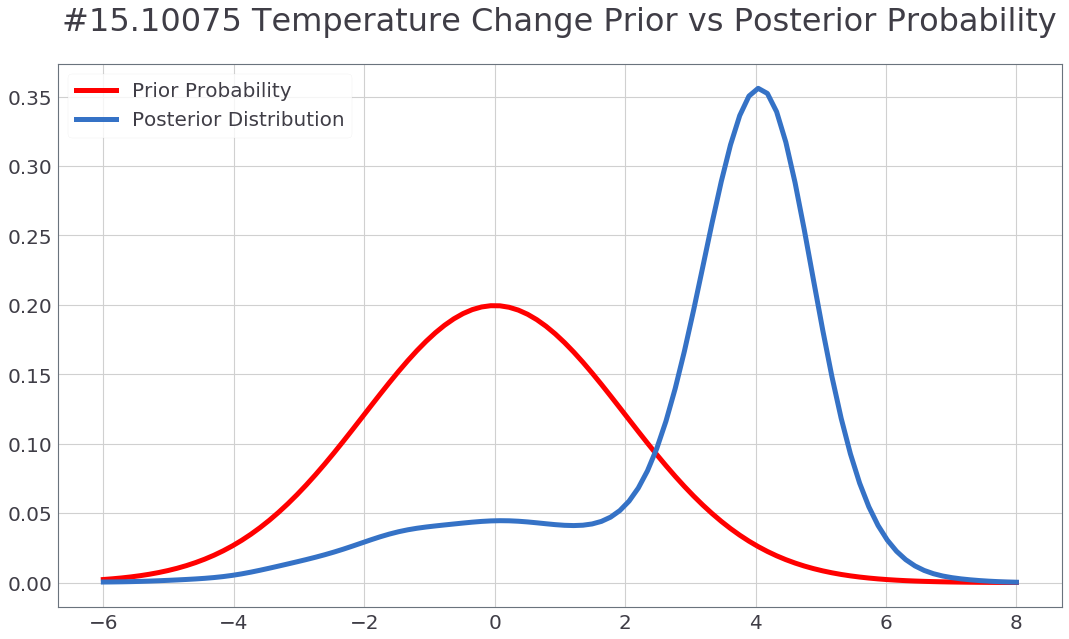

In [19]:
tempchange = traces[(num, '10000')].trace('tempchange')[:]

fig = plt.figure()

# plot the ideal pdf function
mu = 0
sigma = 2
x = np.linspace(mu - 3*sigma, mu + 4*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma), color='red', label = 'Prior Probability', linewidth=5)


# plot the actual density distribution
data = tempchange
density = gaussian_kde(data)
#x = np.linspace(-6, 10, 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x,density(x), label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' Temperature Change Prior vs Posterior Probability', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

#fig.savefig('../probability_plots/' + num + 'tempchange.png')

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  if __name__ == '__main__':


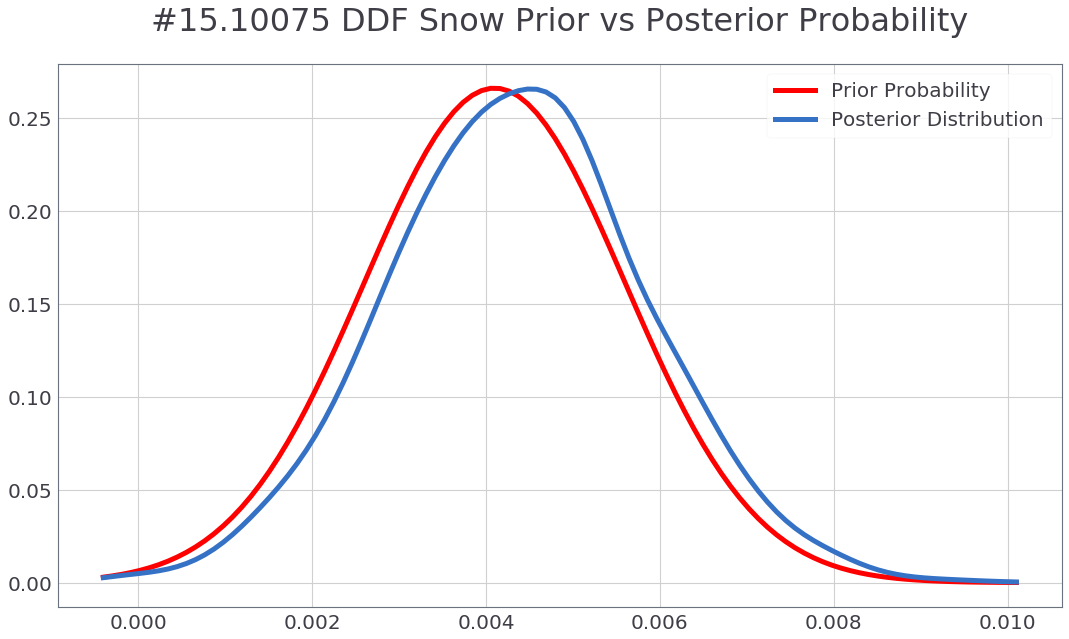

In [20]:
ddfsnow = traces[(num, '10000')].trace('ddfsnow')[:]

fig = plt.figure()

# plot the ideal pdf function
mu = 0.0041
sigma = 0.0015
x = np.linspace(mu - 3*sigma, mu + 4*sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma) /1000, color='red', label = 'Prior Probability', linewidth=5)

# plot the actual density distribution
data = ddfsnow
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x) / 1000, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' DDF Snow Prior vs Posterior Probability', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

#fig.savefig('../probability_plots/' + num + 'ddfsnow.png')

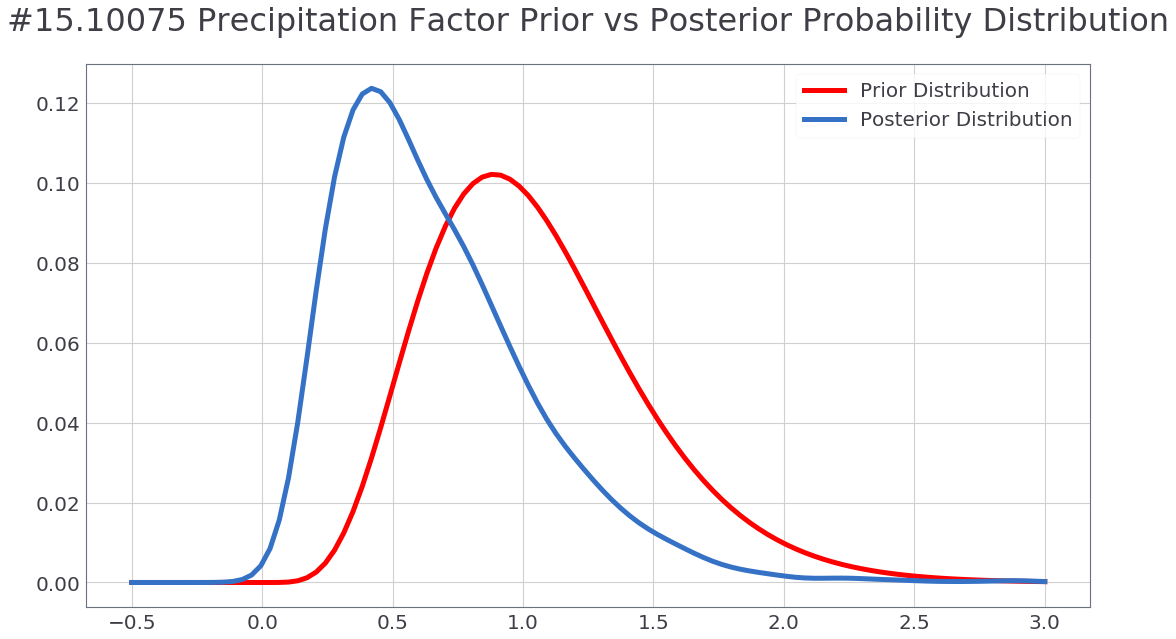

In [22]:
precfactor = traces[(num, '10000')].trace('precfactor')[:]

fig = plt.figure()

x = np.linspace (-0.5, 3.0, 100) 
y = stats.gamma.pdf(x, a= 6.33, scale=(1/6)) #a is alpha, loc is beta???
plt.plot(x, y /10, linewidth =5, label='Prior Distribution', color='red')

# plot the actual density distribution
data = precfactor
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x)/10, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' Precipitation Factor Prior vs Posterior Probability Distribution', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()

#fig.savefig('../probability_plots/' + num + 'precfactor.png')

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()


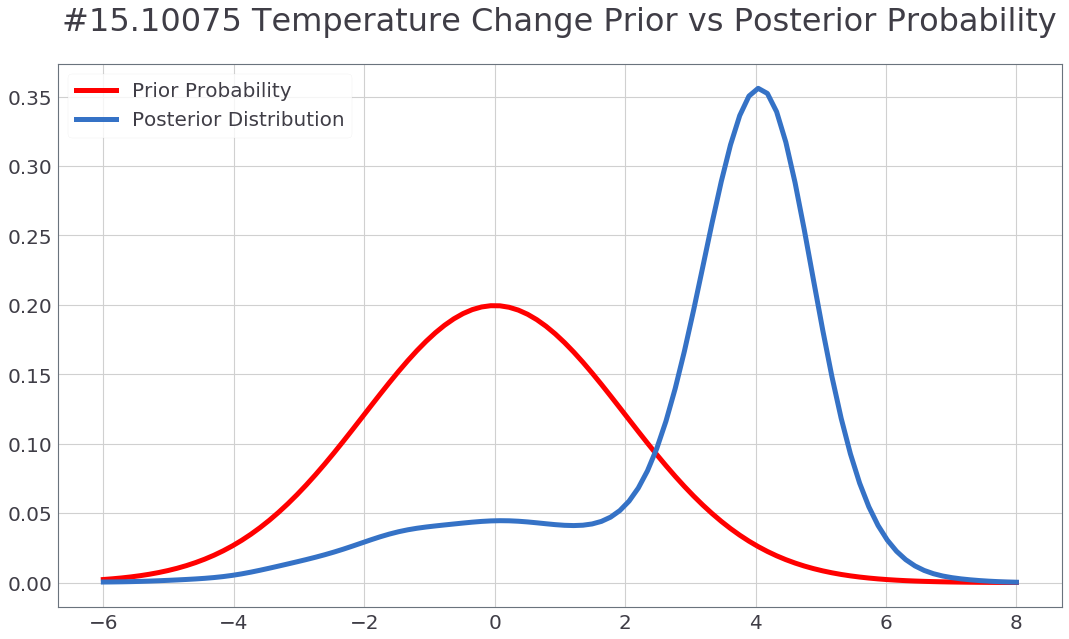

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


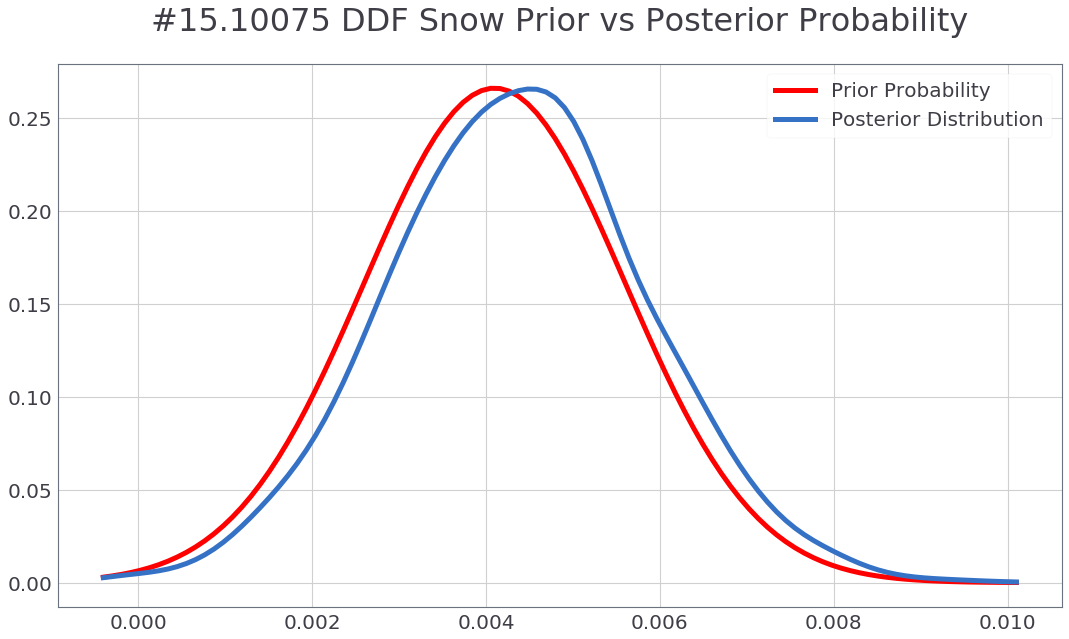

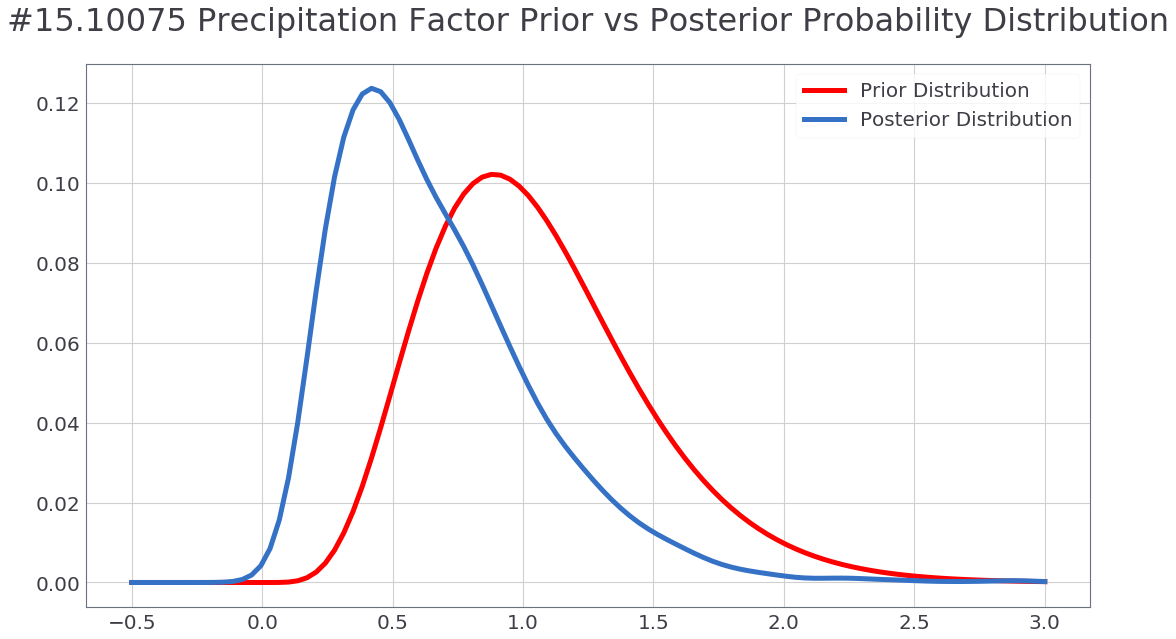

In [27]:
num = '10075'

tempchange = traces[(num, '10000')].trace('tempchange')[:]

fig = plt.figure()

# plot the ideal pdf function
mu = 0
sigma = 2
x = np.linspace(mu - 3*sigma, mu + 4*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma), color='red', label = 'Prior Probability', linewidth=5)


# plot the actual density distribution
data = tempchange
density = gaussian_kde(data)
#x = np.linspace(-6, 10, 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x,density(x), label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' Temperature Change Prior vs Posterior Probability', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

fig.savefig('../probability_plots/' + num + 'tempchange.png')

ddfsnow = traces[(num, '10000')].trace('ddfsnow')[:]

fig = plt.figure()

# plot the ideal pdf function
mu = 0.0041
sigma = 0.0015
x = np.linspace(mu - 3*sigma, mu + 4*sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma) /1000, color='red', label = 'Prior Probability', linewidth=5)

# plot the actual density distribution
data = ddfsnow
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x) / 1000, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' DDF Snow Prior vs Posterior Probability', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

fig.savefig('../probability_plots/' + num + 'ddfsnow.png')

precfactor = traces[(num, '10000')].trace('precfactor')[:]

fig = plt.figure()

x = np.linspace (-0.5, 3.0, 100) 
y = stats.gamma.pdf(x, a= 6.33, scale=(1/6)) #a is alpha, loc is beta???
plt.plot(x, y /10, linewidth =5, label='Prior Distribution', color='red')

# plot the actual density distribution
data = precfactor
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x)/10, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' Precipitation Factor Prior vs Posterior Probability Distribution', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()

fig.savefig('../probability_plots/' + num + 'precfactor.png')

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()


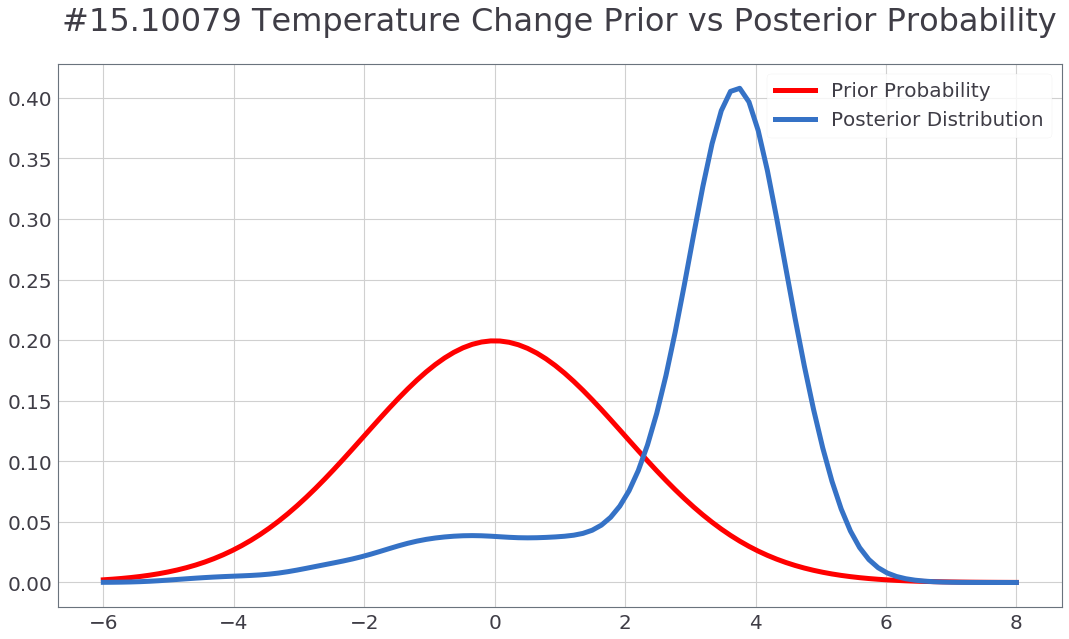

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


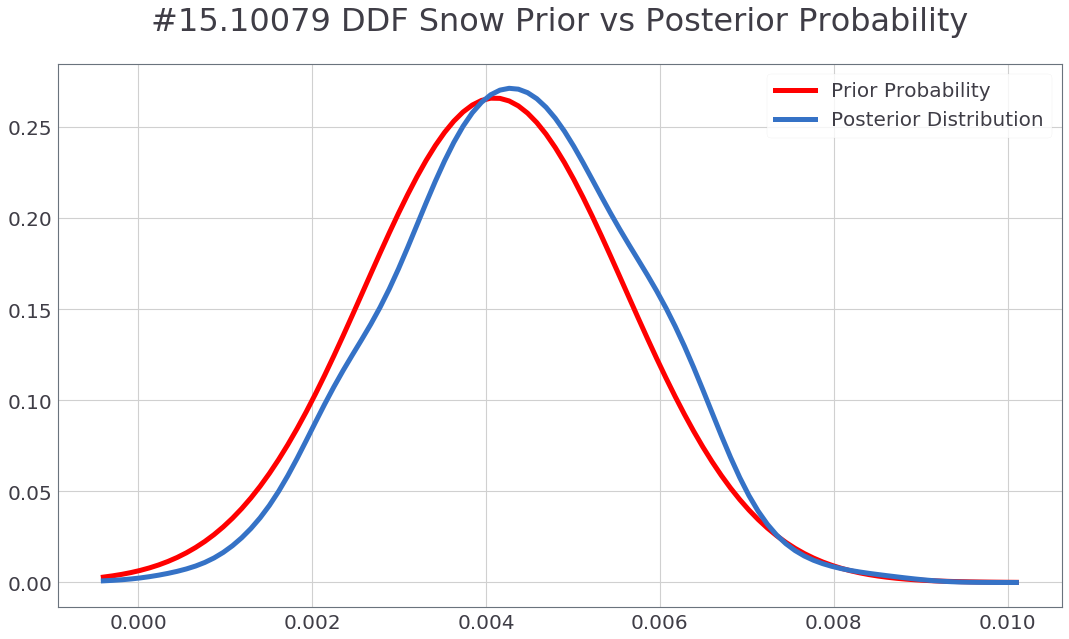

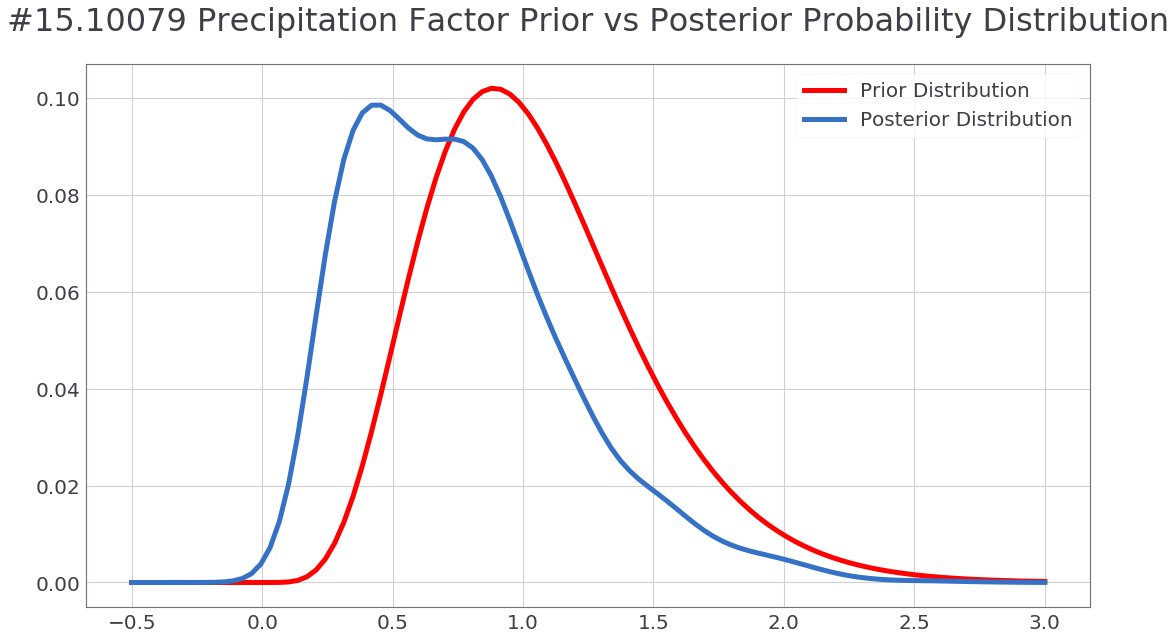

In [28]:
num = '10079'

tempchange = traces[(num, '10000')].trace('tempchange')[:]

fig = plt.figure()

# plot the ideal pdf function
mu = 0
sigma = 2
x = np.linspace(mu - 3*sigma, mu + 4*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma), color='red', label = 'Prior Probability', linewidth=5)


# plot the actual density distribution
data = tempchange
density = gaussian_kde(data)
#x = np.linspace(-6, 10, 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x,density(x), label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' Temperature Change Prior vs Posterior Probability', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

fig.savefig('../probability_plots/' + num + 'tempchange.png')

ddfsnow = traces[(num, '10000')].trace('ddfsnow')[:]

fig = plt.figure()

# plot the ideal pdf function
mu = 0.0041
sigma = 0.0015
x = np.linspace(mu - 3*sigma, mu + 4*sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma) /1000, color='red', label = 'Prior Probability', linewidth=5)

# plot the actual density distribution
data = ddfsnow
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x) / 1000, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' DDF Snow Prior vs Posterior Probability', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

fig.savefig('../probability_plots/' + num + 'ddfsnow.png')

precfactor = traces[(num, '10000')].trace('precfactor')[:]

fig = plt.figure()

x = np.linspace (-0.5, 3.0, 100) 
y = stats.gamma.pdf(x, a= 6.33, scale=(1/6)) #a is alpha, loc is beta???
plt.plot(x, y /10, linewidth =5, label='Prior Distribution', color='red')

# plot the actual density distribution
data = precfactor
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x)/10, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' Precipitation Factor Prior vs Posterior Probability Distribution', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()

fig.savefig('../probability_plots/' + num + 'precfactor.png')

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()


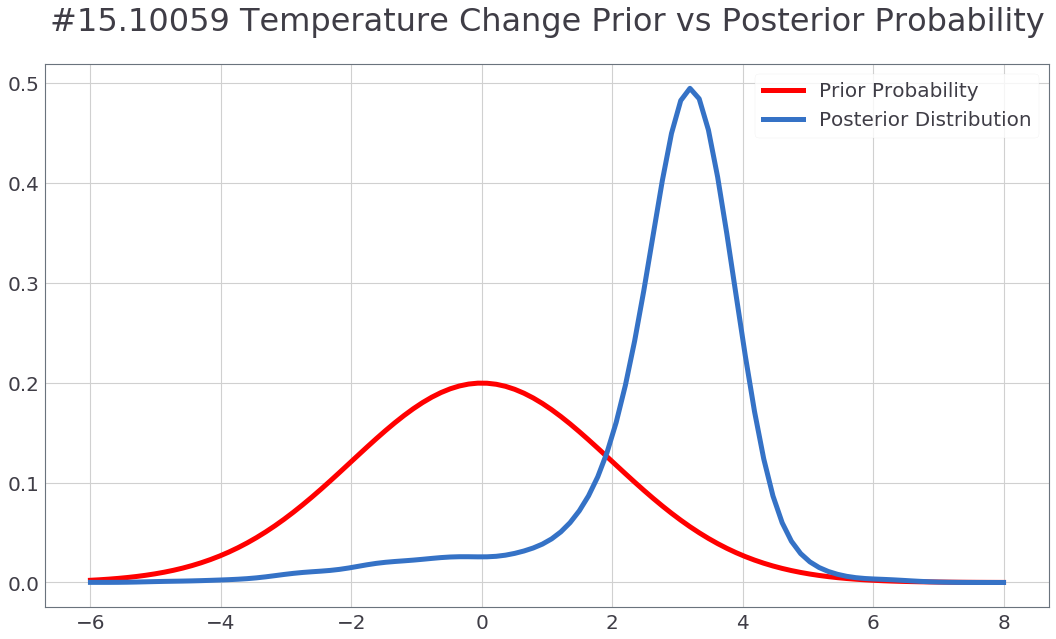

/home/tushar/anaconda3/envs/pymc/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


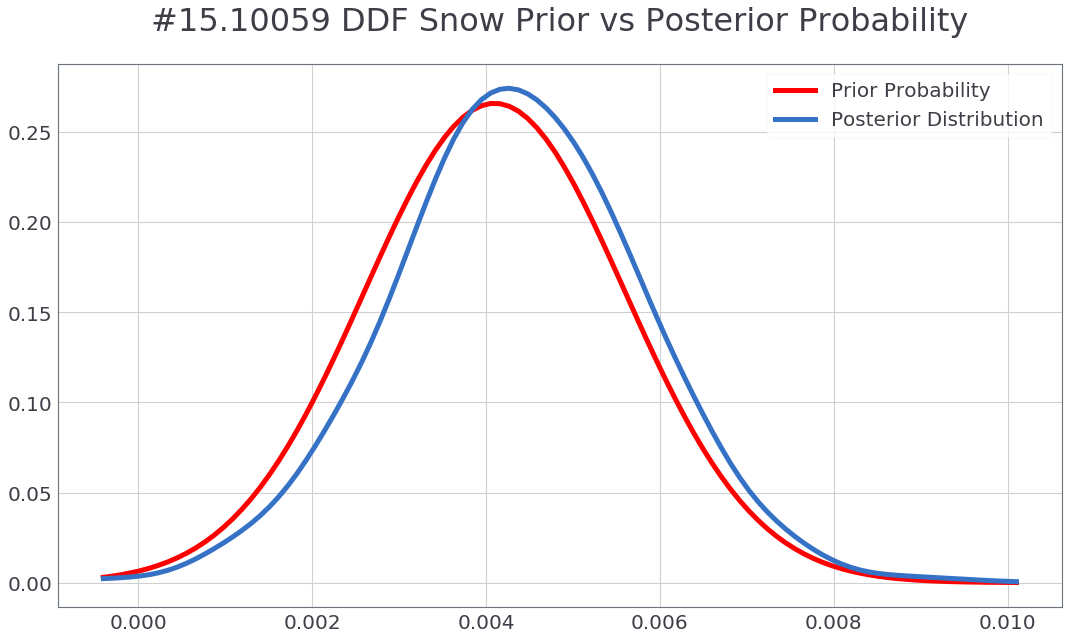

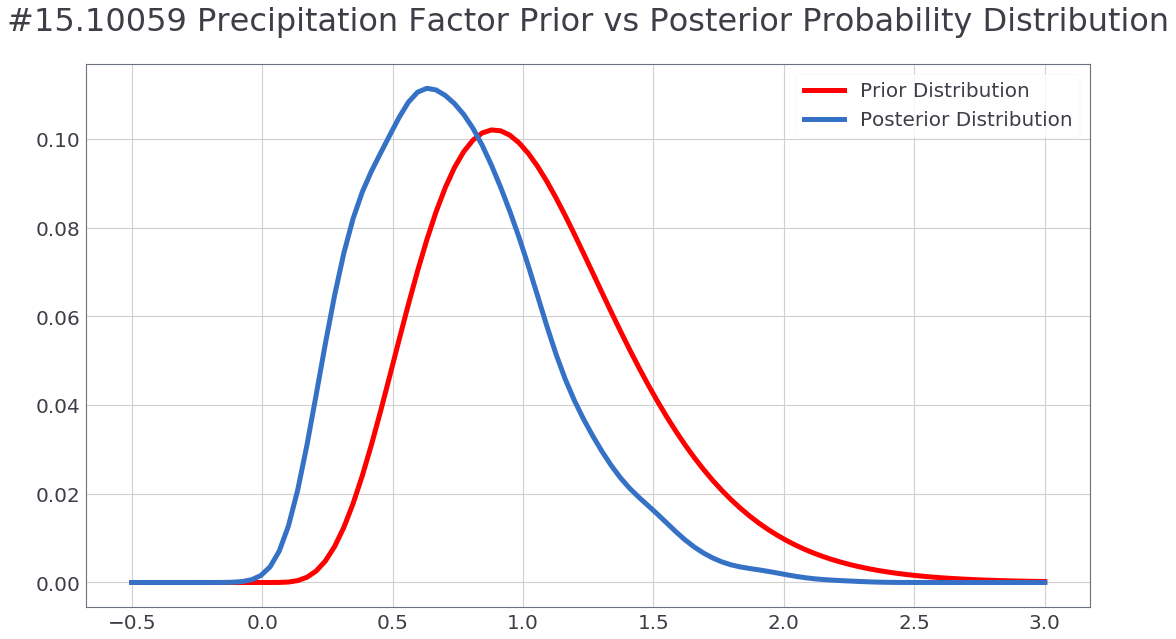

In [30]:
num = '10059'

tempchange = traces[(num, '10000')].trace('tempchange')[:]

fig = plt.figure()

# plot the ideal pdf function
mu = 0
sigma = 2
x = np.linspace(mu - 3*sigma, mu + 4*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma), color='red', label = 'Prior Probability', linewidth=5)


# plot the actual density distribution
data = tempchange
density = gaussian_kde(data)
#x = np.linspace(-6, 10, 200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x,density(x), label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' Temperature Change Prior vs Posterior Probability', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

fig.savefig('../probability_plots/' + num + 'tempchange.png')

ddfsnow = traces[(num, '10000')].trace('ddfsnow')[:]

fig = plt.figure()

# plot the ideal pdf function
mu = 0.0041
sigma = 0.0015
x = np.linspace(mu - 3*sigma, mu + 4*sigma, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma) /1000, color='red', label = 'Prior Probability', linewidth=5)

# plot the actual density distribution
data = ddfsnow
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x) / 1000, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' DDF Snow Prior vs Posterior Probability', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

fig.savefig('../probability_plots/' + num + 'ddfsnow.png')

precfactor = traces[(num, '10000')].trace('precfactor')[:]

fig = plt.figure()

x = np.linspace (-0.5, 3.0, 100) 
y = stats.gamma.pdf(x, a= 6.33, scale=(1/6)) #a is alpha, loc is beta???
plt.plot(x, y /10, linewidth =5, label='Prior Distribution', color='red')

# plot the actual density distribution
data = precfactor
density = gaussian_kde(data)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(x, density(x)/10, label = 'Posterior Distribution', linewidth=5)
plt.legend(loc='best', fontsize=20)

# niceties
plt.title('#15.' + num + ' Precipitation Factor Prior vs Posterior Probability Distribution', fontsize = 32, y=1.05)
#plt.ylabel('Probability', fontsize =24 )
#plt.xlabel('Value', fontsize = 24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.show()

fig.savefig('../probability_plots/' + num + 'precfactor.png')

In [2]:
filelist = glob.glob(os.path.join('../MCMC_data/' , '*.nc'))
print(filelist)
ensembles = {}
samples = []
for f in filelist:
    print(f)
    name = f[38:-32]
    samples.append(name)
    print(name)
    ds = xr.open_dataset(f)
    ensembles[name] = ds

['../MCMC_data/parameter_sets_4glaciers_5000samples_200ensembles_20180729take2.nc', '../MCMC_data/parameter_sets_1glaciers_1000samples_300ensembles_20180728.nc', '../MCMC_data/parameter_sets_4glaciers_10000samples_200ensembles_20180727.nc', '../MCMC_data/parameter_sets_4glaciers_200samples_200ensembles_20180728.nc', '../MCMC_data/parameter_sets_4glaciers_5000samples_200ensembles_20180727.nc', '../MCMC_data/parameter_sets_4glaciers_1000samples_200ensembles_20180727.nc', '../MCMC_data/parameter_sets_4glaciers_30000samples_200ensembles_20180727.nc', '../MCMC_data/parameter_sets_4glaciers_1000samples_200ensembles_20180729take2.nc', '../MCMC_data/parameter_sets_4glaciers_3000samples_200ensembles_20180727.nc']
../MCMC_data/parameter_sets_4glaciers_5000samples_200ensembles_20180729take2.nc
5000sampl
../MCMC_data/parameter_sets_1glaciers_1000samples_300ensembles_20180728.nc
1000
../MCMC_data/parameter_sets_4glaciers_10000samples_200ensembles_20180727.nc
10000
../MCMC_data/parameter_sets_4glaci

In [3]:
glaciers = ['15.1006', '15.10059', '15.10075', '15.10079']
variabl = ['massbal']#, 'precfactor', 'ddfsnow', 'massbal']
samples.sort()
samples = ['1000', '3000', '5000', '10000', '30000']

In [4]:
def get_glacier_data(glacier_number):
            '''
            Returns the mass balance and error estimate for
            the glacier from David Shean's DEM data


            Parameters
            ----------
            glacier_number : float
                RGI Id of the glacier for which data is to be
                returned. Should be a number with a one or two
                digit component before the decimal place
                signifying glacier region, and 5 numbers after
                the decimal which represent glacier number.
                Example: 15.03733 for glacier 3733 in region 15


            Returns
            -------
            (tuple)
            massbal : float
                average annual massbalance over david sheans's
                dataset
            stdev : float
                estimate error (standard deviation) of measurement
            index : int
                index of glacier in csv file for debugging

            '''

            #convert input to float
            glacier_number = float(glacier_number)

            # upload csv file of DEM data and convert to
            # dataframe
            csv_path = '../DEMs/hma_mb_20171211_1343.csv'
            df = pd.read_csv(csv_path)

            # locate the row corresponding to the glacier
            # with the given RGIId number
            row = df.loc[round(df['RGIId'], 5) == glacier_number]

            # get massbalance, measurement error (standard
            # deviation) and index of the
            # glacier (index for debugging purposes)
            index = row.index[0]
            massbal = row['mb_mwea'][index]
            stdev = row['mb_mwea_sigma'][index]

            return massbal, stdev, index

In [5]:
np.mean(ensembles['30000']['15.10075'].sel(variables='massbal').values)

0.25761620229183041

In [6]:

for glac in glaciers:
    print(glac)
    mean, std, index = get_glacier_data(float(glac))
    print('observed mean, std:', mean, std, index)
    #for key, val in ensembles.items():
    for sample in samples:
        val = ensembles[sample]
        print(sample)
    
        for var in variabl:
            print(var)
            mean = np.mean(val[glac].sel(variables=var).values)
            std = np.std(val[glac].sel(variables=var).values)
            print('mean:', mean, 'std:', std)
        

15.1006
observed mean, std: -0.041 0.239 3
1000
massbal
mean: 0.0485333188266 std: 0.237568151107
3000
massbal
mean: 0.067505779678 std: 0.255946164863
5000
massbal
mean: 0.0580876731769 std: 0.250958968707
10000
massbal
mean: 0.0462780729628 std: 0.242817111123
30000
massbal
mean: 0.0564343342403 std: 0.251202397916
15.10059
observed mean, std: 0.074 0.237 2
1000
massbal
mean: 0.216274570474 std: 0.244817067067
3000
massbal
mean: 0.261092985526 std: 0.266327055556
5000
massbal
mean: 0.205778161922 std: 0.24982517005
10000
massbal
mean: 0.194019513758 std: 0.249969279872
30000
massbal
mean: 0.196155249536 std: 0.250257559106
15.10075
observed mean, std: 0.084 0.24 0
1000
massbal
mean: 0.296195645042 std: 0.260783993624
3000
massbal
mean: 0.204392290351 std: 0.254536689438
5000
massbal
mean: 0.241138062934 std: 0.254339059152
10000
massbal
mean: 0.274163802237 std: 0.264499436747
30000
massbal
mean: 0.257616202292 std: 0.263810390215
15.10079
observed mean, std: 0.082 0.238 1
1000
massb

In [105]:
ensembles['1000']['15.1006'].sel(variables='tempchange')

<xarray.DataArray '15.1006' (runs: 200)>
array([ 2.188107,  2.188107,  2.188107,  2.791304,  2.716221,  2.306758,
        2.306758,  2.320939,  2.320939,  2.676396,  2.458666,  2.684647,
        2.479075,  3.370174,  3.370174,  2.887615,  2.887615,  2.125781,
        2.125781,  0.899419,  2.477995,  2.478984,  3.252994,  3.252994,
        3.29834 ,  3.29834 ,  2.374229,  2.374229,  2.239797,  1.014241,
        2.869379,  1.472456,  2.244555,  2.029186,  2.029186,  2.642548,
        3.302095,  2.915113,  2.915113,  2.868803,  2.290042,  2.290042,
        2.290042,  2.836791,  2.836791,  2.764643,  2.764643,  2.764643,
        2.426777,  2.280555,  2.42327 ,  2.010638,  2.632609,  2.632609,
        2.097875,  4.202466,  3.760174,  3.760174,  3.718561,  2.772188,
        2.772188,  3.009554,  2.780785,  2.186985,  2.242949,  2.242949,
        2.242949,  2.90643 ,  3.477393,  3.477393,  3.626729,  3.626729,
        4.319518,  4.010175,  4.010175,  2.442332,  2.442332,  2.379803,
        0.